# AI Investment Analyst

An agent that:

* Scrapes financial news + quarterly reports

* Runs sentiment analysis

* Combines with stock fundamentals

* Generates investment theses (bullish/bearish)

* Could integrate with Yahoo Finance API for real-time data.

# Imports

In [1]:
!pip install -U langgraph "langchain[openai]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 17.5 MB/s eta 0:00:00


In [2]:
!pip install -qU \
  langchain-core==0.3.33 \
  langchain-openai==0.3.3 \
  langchain-community==0.3.16
!pip install -U langchain pydantic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 47.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langgraph-prebuilt 0.6.4 requires langchain-core>=0.3.67, but you have langchain-core 0.3.33 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.0 MB/s eta 0:00:00
   ━━━

In [3]:
!pip install langgraph

In [4]:
!pip install yfinance


In [5]:
from typing import Annotated, TypedDict, List, Dict, Any, Optional
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from IPython.display import Image, display
import gradio as gr
import uuid
from dotenv import load_dotenv
import os
from langchain.agents import tool,Tool

# Set LangSmith

In [140]:
f=open("/content/LangSmith API.txt","r")
smith_api_key=f.read()
os.environ["LANGCHAIN_API_KEY"] = smith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "My-AI-Investor"

# Some Tools That My Model Should Use

In [141]:
f=open("/content/Serper APIkey.txt","r")
S_api_key=f.read()
os.environ["SERPER_API_KEY"] = S_api_key


In [142]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()

In [143]:
import yfinance as yf

def get_fin_data(ticker:str):
  """Find financial data about a stock
  Args:
        ticker: The ticker of a company you are looking for"""

  stock = yf.Ticker(ticker)
  fin_data=stock.financials.to_string()

  return fin_data

tool_fin_data = Tool(
        name="Data_fin",
        func=get_fin_data,
        description="useful when you need to search into the web for financial data of a stock"
    )


In [144]:
def serper_search(ticker:str):
  """Find financial news about a stock
  Args:
        ticker: The ticker of a company in order to find news about it """
  return serper.run(f"Find financial data about {ticker}")

tool_search_news = Tool(
        name="news_search",
        func=serper_search,
        description="useful when you need to search into the web for financial news about a company"
    )

tools=[tool_fin_data,tool_search_news]

# My Models

In [145]:

f=open("/content/OpenAIKey.txt","r")
api_key=f.read()



llm = ChatOpenAI(
    model_name="x-ai/grok-4-fast:free",
    openai_api_key=api_key,
    openai_api_base="https://openrouter.ai/api/v1",
    temperature=0.0)

In [146]:
llm_with_tools=llm.bind_tools(tools)

# Let's Create Our Agent

* Create The State

In [147]:
#State
from langgraph.channels.last_value import LastValue
class Fin_State(TypedDict):
  ticker: str
  financials: Annotated[str, LastValue]
  news: Annotated[List[str], LastValue]
  summary: Annotated[str, LastValue]
  sentiment: Annotated[str, LastValue]
  report: Annotated[str, LastValue]
  messages: Annotated[List[Any], add_messages]

* Create Nodes

In [148]:
def data_fetch(state: Fin_State) -> Fin_State:
  prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an AI financial analyst. You MUST use the available tools to gather:
        - Financial statements and data for {ticker} using the tool_fin_data tool
        - Latest news and market sentiment for {ticker} using the tool_search_news tool

        IMPORTANT: Always call both tools to get comprehensive information before proceeding."""),
        ("human", "Gather complete financial data and latest news for {ticker} stock. Use the tools provided.")])

  chain_0 = prompt | llm_with_tools
  response = chain_0.invoke({"ticker": state["ticker"]})

  return {**state, "messages": state["messages"] + [response]}

In [149]:
def sum_fin_report(state:Fin_State)->Fin_State:
  prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a financial analyst that does summary on financial data about a company. "),
        ('user',f"Make a summary about this company's financial data \n {state['financials']} ")])

  chain_1=prompt|llm

  summary=chain_1.invoke(state).content
  return {**state, "summary": summary}


In [150]:
def sentiment_analysis(state:Fin_State)-> Fin_State:
  news_text='\n'.join(state['news'])
  prompt = ChatPromptTemplate.from_messages([
        ("system","You are a news sentiment analyst. You can use tools in order to find news online about a stock and also you can classify them as positive, neutral or negative."),
        ("user", "Analyze sentiment the following news article:\n\n{news}")])

  chain_2=prompt|llm

  sentiment=chain_2.invoke({'news':news_text}).content
  return {**state, "sentiment": sentiment}



In [151]:
def report_analyst(state:Fin_State)->Fin_State:
  prompt = ChatPromptTemplate.from_messages([
        ("system","""You are an ai investment strategist. Given some sentiment analysis and a summary of the financial data of a company, you can create an investment report.
        You help the user to deside if this company is a good investment oportunity or not"""),
        ("user", "Write an investment report combining:\n\n Summary : {summary} \n\n Sentiment:{sentiment}")])

  chain_3=prompt|llm
  report=chain_3.invoke(state).content
  return {**state, "report": report}



In [152]:
def process_tool_results(state: Fin_State) -> Fin_State:
  last_message = state["messages"][-1]

  if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
      for tool_call in last_message.tool_calls:
          if tool_call['name'] == 'Data_fin':
              state = {**state, "financials": tool_call['result']}
          elif tool_call['name'] == 'news_search':
              state = {**state, "news": state["news"] + [tool_call['result']]}

  return state

In [153]:
builder=StateGraph(Fin_State)

builder.add_node('data_fetch',data_fetch)
builder.add_node('tools',ToolNode(tools=tools))
builder.add_node('sum_fin_report',sum_fin_report)
builder.add_node('sentiment_analysis',sentiment_analysis)
builder.add_node('report_analyst',report_analyst)
builder.add_node('process_tools', process_tool_results)

In [154]:
def my_tools_condition(state):
  next_node = tools_condition(state)
  if next_node == END:
      return "sum_fin_report"
  return next_node

def should_use_tools(state):
  last_message = state["messages"][-1]
  if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
      return "tools"
  return "sum_fin_report"


In [155]:
builder=StateGraph(Fin_State)

builder.add_node('data_fetch',data_fetch)
builder.add_node('tools',ToolNode(tools=tools))
builder.add_node('sum_fin_report',sum_fin_report)
builder.add_node('sentiment_analysis',sentiment_analysis)
builder.add_node('report_analyst',report_analyst)
builder.add_node('process_tools', process_tool_results)

builder.add_edge(START,'data_fetch')
builder.add_conditional_edges('data_fetch', tools_condition,"tools")
builder.add_edge('tools','process_tools')
builder.add_edge('process_tools','data_fetch')
builder.add_edge('data_fetch','sum_fin_report')
builder.add_edge('sum_fin_report','sentiment_analysis')
builder.add_edge('sentiment_analysis','report_analyst')
builder.add_edge('report_analyst',END)
graph=builder.compile()

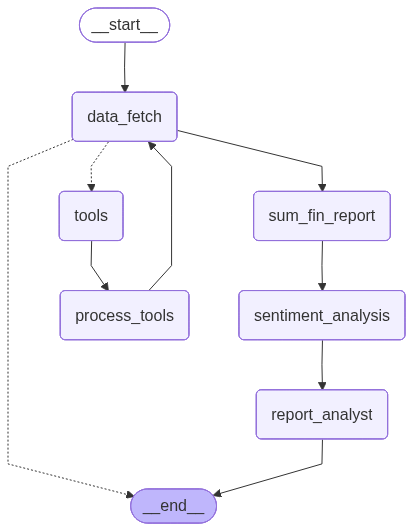

In [156]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [157]:
state = {
    "ticker": "AAPL",
    "financials": "",
    "news": [],
    "summary": "",
    "sentiment": "",
    "report": "",
    "messages": [HumanMessage(content="Find financial data and latest news for Apple")]
}

final_state = graph.invoke(state)

print("\n=== Final Report ===\n")
print(final_state["report"])

InvalidUpdateError: At key 'ticker': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE